In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from os.path import join as oj
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from random import randint
from style import *
from captum.attr import *
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF, LatentDirichletAllocation
from transform_wrappers import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
import pandas as pd
from models import FNN
import attributions
device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
out_dir = '/scratch/users/vision/data/cosmo/sim'
dirs = sorted(os.listdir(out_dir))
print(dirs)

['fft', 'fft_unif', 'identity', 'identity_unif']


In [21]:
results_list = []
for dirname in dirs:
    fname = os.listdir(oj(out_dir, dirname))[0]
    results_list.append(pkl.load(open(oj(out_dir, dirname, fname), 'rb')))
results = pd.DataFrame(results_list)
results.insert(0, 'dir', dirs)
print(results.acc_test)

0    0.95216
1    0.87856
2    0.97904
3    0.97944
Name: acc_test, dtype: float64


In [ ]:
results

In [45]:
# colors = [cb, cr, 'purple', 'green']
R = results.shape[0]
d = {'attr_method': [], 'errs': [], 'setting': []}
for i in range(R):
    row = results.iloc[i]
    r = row['results']

    accs = []
    ks = sorted(r.keys())
    for k in ks:
        attrs = np.vstack(r[k])
        args = np.argmax(attrs, axis=1)
        num_correct = np.sum(args == row['idx_knockout'])
        acc = num_correct / args.size
        accs.append(num_correct / args.size)
        d['attr_method'].append(k)
        d['errs'].append(1 - acc)
        d['setting'].append(row.dir)
    '''
    plt.figure(facecolor='white')
    plt.title(f'{row.dir} {row.acc_test:.2f}')
    plt.bar(ks, (1-np.array(accs)))
    plt.ylabel('classification err')
    plt.savefig(f'fig_sim_{row.dir}.pdf')
    plt.show()
    '''

In [46]:
df = pd.DataFrame.from_dict(d)

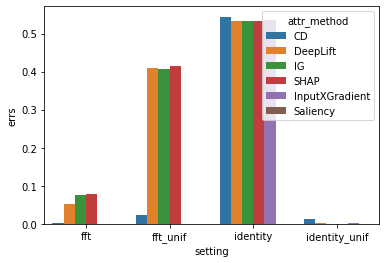

In [49]:
sns.barplot(x='setting', y='errs', hue='attr_method', data=df)
plt.savefig('fig_sim.pdf')

In [32]:
df

,ks,accs,setting
0,CD,0.9985,fft
1,DeepLift,0.9480,fft
2,IG,0.9240,fft
3,SHAP,0.9225,fft
4,CD,0.9760,fft_unif
5,DeepLift,0.5900,fft_unif
6,IG,0.5920,fft_unif
7,SHAP,0.5860,fft_unif
8,CD,0.4560,identity
9,DeepLift,0.4660,identity


In [23]:
prob = 0.948
num = 1000
print(np.sqrt(prob * (1-prob)) / np.sqrt(num))

0.007021111023192843


In [172]:
# d = scores.size
# idxs = np.zeros(d).astype(bool)
# idxs[idx_zero - window: idx_zero + window + 1] = 1
# plt.plot(np.arange(d)[idxs], scores[idxs], 'o')
# plt.plot(np.arange(d)[~idxs], scores[~idxs], 'o')
# plt.show()

In [9]:
r = results[results.dir == 'nmf_unif2'].iloc[0]
y = r.preds

for key in r.results:
    attrs = np.vstack(r.results[key].values)
    attrs_pos = attrs[y==1]
    attrs_neg = attrs[y==0]

    acc = np.mean(np.argmax(attrs, axis=1) == 12)
    acc_pos = np.mean(np.argmax(attrs_pos, axis=1) == 12)
    print(key, acc, acc_pos)

CD 0.996 1.0
DeepLift 0.996 1.0
IG 0.996 1.0
SHAP 0.996 1.0


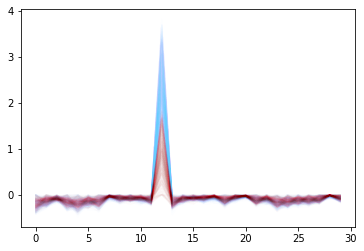

In [209]:
plt.plot(attrs_pos.T, alpha=0.01, color=cb)
plt.plot(attrs_neg.T, alpha=0.01, color=cr)
plt.show()

# check that hyperparams are correct

In [ ]:
results.drop('results', axis=1)

# visualize bases

In [ ]:
def viz_basis(D, R=5, C=6):
    i = 0
    vmin = np.min(D)
    vmax = np.max(D)
    plt.figure(figsize=(C * 3, R * 3), dpi=200)
    for r in range(R):
        for c in range(C):
            plt.subplot(R, C, i + 1)
            plt.plot(D[i]) #, vmin=vmin, vmax=vmax, cmap='viridis')
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()

In [ ]:
fname = 'lda_30_uniform.pkl'
D = pkl.load(open(fname, 'rb')).components_
viz_basis(D)